## **Text Summarization using LLM (BART) with Dataset**

In [4]:
# Install necessary libraries
!pip install datasets transformers --quiet

# Disable Weights & Biases logging
import os
os.environ["WANDB_DISABLED"] = "true"

# Set up
from transformers import BartTokenizer, BartForConditionalGeneration
from datasets import load_dataset
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset
dataset = load_dataset("cnn_dailymail", "3.0.0")
train_data = dataset["train"].select(range(100))  # 100 samples only for fast test
val_data = dataset["validation"].select(range(20))

# Load model/tokenizer
model_name = "sshleifer/distilbart-cnn-12-6"
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name).to(device)

# Preprocessing function
def preprocess(examples):
    inputs = tokenizer(examples["article"], max_length=512, truncation=True, padding="max_length", return_tensors="pt")
    targets = tokenizer(examples["highlights"], max_length=64, truncation=True, padding="max_length", return_tensors="pt")
    inputs["labels"] = targets["input_ids"]
    return inputs

# Preprocess data manually (no map to save time)
train_batches = [preprocess(train_data[i]) for i in range(len(train_data))]
val_batches = [preprocess(val_data[i]) for i in range(len(val_data))]

# Create simple dataloaders
def collate_fn(batch):
    input_ids = torch.cat([b["input_ids"] for b in batch])
    attention_mask = torch.cat([b["attention_mask"] for b in batch])
    labels = torch.cat([b["labels"] for b in batch])
    return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

train_loader = DataLoader(train_batches, batch_size=2, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_batches, batch_size=2, shuffle=False, collate_fn=collate_fn)

# Simple optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# Training loop
model.train()
for epoch in range(1):
    print(f"\nEpoch {epoch+1}")
    total_loss = 0
    for batch in tqdm(train_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
    print(f"Avg Loss: {total_loss / len(train_loader):.4f}")

# Evaluate on 1 sample
model.eval()
sample = val_data[0]["article"]
reference = val_data[0]["highlights"]
inputs = tokenizer(sample, return_tensors="pt", truncation=True, max_length=512).to(device)
summary_ids = model.generate(inputs["input_ids"], max_new_tokens=60)
summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Print output
print("\n📄 Original Article:\n", sample[:500], "...")
print("\n✅ Reference Summary:\n", reference)
print("\n✨ Generated Summary:\n", summary)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]


Epoch 1



100%|██████████| 50/50 [22:13<00:00, 26.66s/it]


Avg Loss: 2.6361

📄 Original Article:
 (CNN)Share, and your gift will be multiplied. That may sound like an esoteric adage, but when Zully Broussard selflessly decided to give one of her kidneys to a stranger, her generosity paired up with big data. It resulted in six patients receiving transplants. That surprised and wowed her. "I thought I was going to help this one person who I don't know, but the fact that so many people can have a life extension, that's pretty big," Broussard told CNN affiliate KGO. She may feel guided in her ge ...

✅ Reference Summary:
 Zully Broussard decided to give a kidney to a stranger .
A new computer program helped her donation spur transplants for six kidney patients .

✨ Generated Summary:
 Zully Broussard gave one of her kidneys to a stranger, her generosity paired up with big data .
Five surgeons, a covey of physician assistants, nurses and anesthesiologists to perform surgeries on 12 people .
The ages of the donors and recipients range from 26


## **Image Captioning using CNN + LSTM with Dataset**

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 2.7213
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - loss: 2.4298
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 2.1173
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 2.1858
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 2.0717
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - loss: 2.1646
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - loss: 2.1135
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - loss: 1.9666
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - loss: 1.7899
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - loss: 1.7038


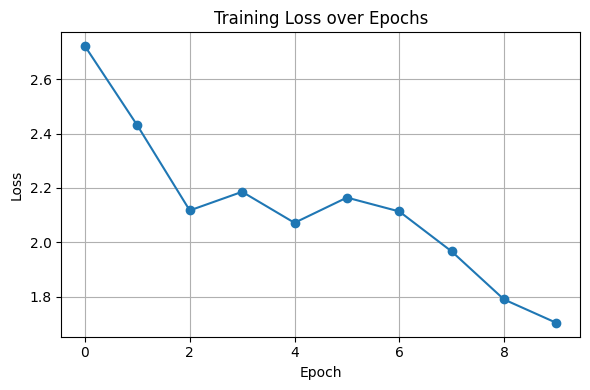

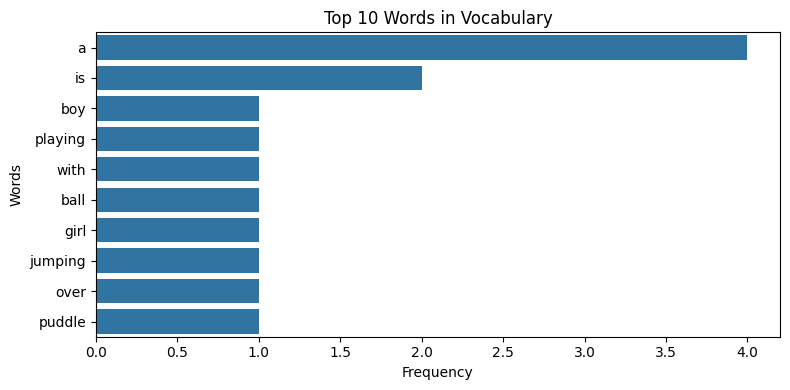

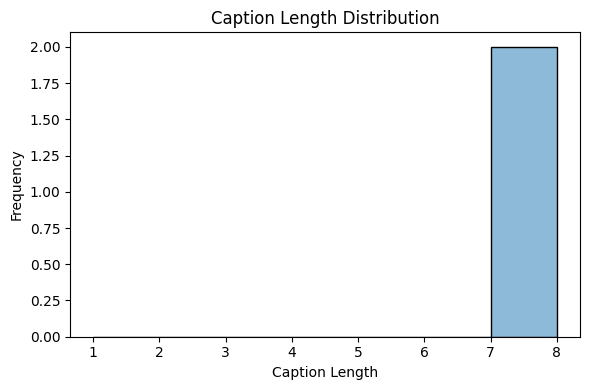

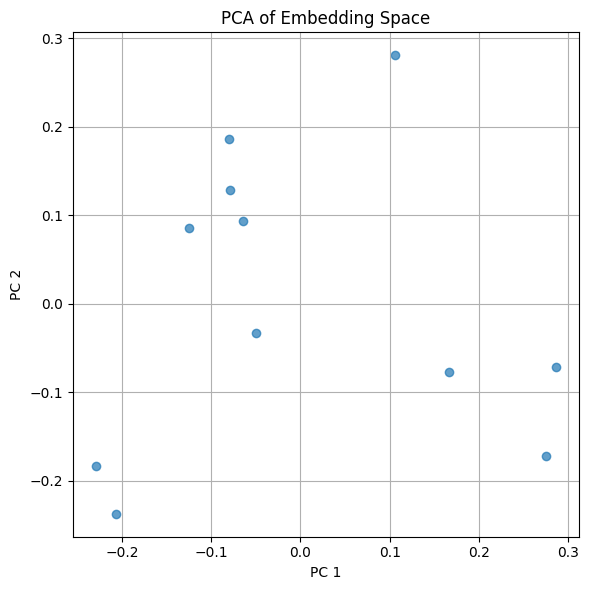


Sample training sequences (decoded):
Input Seq: a → Target Word: boy
Input Seq: a boy → Target Word: is
Input Seq: a boy is → Target Word: playing


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Dummy Flickr8k-style dataset for demo
captions = {
    'image1.jpg': ['a boy is playing with a ball'],
    'image2.jpg': ['a girl is jumping over a puddle']
}

# Feature extractor
base_model = ResNet50(weights='imagenet')
cnn_model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)

def extract_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = cnn_model.predict(x)
    return features[0]

# Tokenizer
all_captions = sum(captions.values(), [])
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

max_len = 10
X1, X2, y = [], [], []
for img, caps in captions.items():
    feat = np.random.rand(2048)  # Replace with extract_features(img)
    for cap in caps:
        seq = tokenizer.texts_to_sequences([cap])[0]
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen=max_len)[0]
            X1.append(feat)
            X2.append(in_seq)
            y.append(out_seq)

X1, X2, y = np.array(X1), np.array(X2), np.array(y)

# Define model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_len,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder = Dense(256, activation='relu')(fe2 + se3)
outputs = Dense(vocab_size, activation='softmax')(decoder)

from tensorflow.keras.models import Model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

# Train model
history = model.fit([X1, X2], y, epochs=10, verbose=1)

# Plot loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()